In [57]:
import torch 
import torch.nn.functional as F
from tqdm import notebook 
import random  
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

In [3]:
words = open('names.txt', 'r').read().splitlines() 
words[:5] 

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
print("Number of names: ", len(words))

Number of names:  32033


In [5]:
min(len(w) for w in words), max(len(w) for w in words)

(2, 15)

In [12]:
chars = sorted(list(set(''.join(words)))) 
stoi = {s:i+1 for i, s in enumerate(chars)}  
stoi['.'] = 0
len(stoi)  
itos = {i:s for s,i in stoi.items()} 

# Bigram Model

In [13]:
# create dataset  
X_bigram, Y_bigram = [], [] 

for word in words: 
    # Adding special token each word
    chars = ['.'] + list(word) + ['.'] 
    for char_1, char_2 in zip(chars, chars[1:]): 
        ix_1 = stoi[char_1] 
        ix_2 = stoi[char_2]   

        X_bigram.append(ix_1) 
        Y_bigram.append(ix_2) 

X_bigram = torch.tensor(X_bigram) 
Y_bigram = torch.tensor(Y_bigram) 

In [14]:
print(X_bigram) 
print(Y_bigram)

tensor([ 0,  5, 13,  ..., 25, 26, 24])
tensor([ 5, 13, 13,  ..., 26, 24,  0])


In [ ]:
class BigramModel: 
    def __init__(self,
                 num_features, 
                 num_out, 
                 num_epochs, 
                 learning_rate, 
                 logging=False, 
                 regularize=False, 
                 smooth_strength=None, 
                 seed=123, 
                 enable_tqdm=True,
                 *args,
                 **kwargs): 
        # Initializes BigramModel instance 
        self.num_features = num_features 
        self.num_out = num_out 
        self.num_epochs = num_epochs 
        self.learning_rate = learning_rate
        self.logging = logging 
        self.regularize = regularize  
        self.smooth_strength = smooth_strength 
        self.seed = seed 
        self.enable_tqdm = enable_tqdm 
        # Generating random weights based on a random seed
        g = torch.Generator().manual_seed(seed)  
        self.weights = torch.randn((num_features, num_out), generator=g)
        self.weights.requires_grad = True

    def __call__(self, x, y):  
        """makes a softmax forward pass and compute the NLL loss"""
        # One hot encoding NN inputs 
        x_encoded = F.one_hot(x, num_classes=self.num_out).float() 
        # computing predictions for log-counts 
        logits = x_encoded @ self.weights 
        # retrieving counts 
        counts = logits.exp() 
        # computing probs for next character 
        probas = counts / counts.sum(1, keepdims=True)  

        # computing loss 
        if self.regularize: 
            if self.smooth_strength is None: 
                raise ValueError("Regularization rate not specified") 
            loss = -probas[torch.arange(x.shape[0]), y].log().mean() + self.smooth_strength * (self.weights**2).mean() 
        else: 
            loss = -probas[torch.arange(x.shape[0]), y].log().mean() 
        
        return loss

    def fit(self, x, y): 
        loss_per_epoch = {} 
        epoch_counter = notebook.tqdm(range(self.num_epochs)) if self.enable_tqdm else range(self.num_epochs)
        for k in epoch_counter: 
            # making a forward pass and computing a loss 
            loss = self(x, y)  
            loss_per_epoch[f"epoch_{k+1}"] = loss.item() 
            if self.logging:
                print(f"Epoch {k+1:03d}/{self.num_epochs:03d}: loss= {loss.item():.4f}")
            # setting gradients to zero 
            self.weights.grad = None 
            loss.backward() 
            # updating weights (SGD) 
            self.weights.data += -self.learning_rate * self.weights.grad
        self.history = loss_per_epoch 

    def generate_sample(self, num_examples, itos): 
        g = torch.Generator().manual_seed(self.seed) 
        generated_names = [] 
        for i in range(num_examples): 
            out = [] 
            ix = 0  
            while True: 
                # One hot encoding
                x_encoded = F.one_hot(torch.tensor([ix]), num_classes=self.num_out).float()
                # computing predictions
                logits = x_encoded @ self.weights
                counts = logits.exp()
                probas = counts / counts.sum(1, keepdims=True)
                # next character
                ix = torch.multinomial(probas, num_samples=1, replacement=True, generator=g).item()
                
                out.append(itos[ix])
                if ix == 0:  
                    break
            generated_names.append(''.join(out)[:-1])  
        
        return generated_names

In [16]:
bigram_model = BigramModel(
    num_features=27, 
    num_out=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

# Launching training process
bigram_model.fit(X_bigram, Y_bigram)

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
# Generating 10 new examples
bigram_model.generate_sample(num_examples=10, itos=itos)

['ayl',
 'eeiey',
 'viannmonind',
 'pidouyra',
 'jon',
 'cerrdyanaya',
 'kseli',
 'peyussmon',
 'zzolie',
 'e']

# Exercise 1

## Trigram Model 

In [19]:
X_trigram, Y_trigram = [], []
for word in words:
    # Adding special token for each word
    chars = ['.'] + list(word) + ['.']
    for char_1, char_2, char_3 in zip(chars, chars[1:], chars[2:]):
        # Getting the indices of a letter
        ix_1 = stoi[char_1]
        ix_2 = stoi[char_2]
        ix_3 = stoi[char_3]
        
        # Adding letter indices to lists
        X_trigram.append([ix_1, ix_2])
        Y_trigram.append(ix_3)

# Casting as PyTorch tensors
X_trigram = torch.tensor(X_trigram)
Y_trigram = torch.tensor(Y_trigram)

In [20]:
print(X_trigram) 
print(Y_trigram)

tensor([[ 0,  5],
        [ 5, 13],
        [13, 13],
        ...,
        [26, 25],
        [25, 26],
        [26, 24]])
tensor([13, 13,  1,  ..., 26, 24,  0])


In [30]:
class TrigramModel(BigramModel):
    def __init__(self, *args, **kwargs):
        """Inherits initialization schema from BigramModel class."""
        super().__init__(*args, **kwargs)
    
    def __call__(self, x, y):
        """Makes a softmax forward pass and computes the NLL loss."""
        x_encoded = F.one_hot(x, num_classes=self.num_out).float().view(-1, self.num_features)
        logits = x_encoded @ self.weights # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        probas = counts / counts.sum(1, keepdims=True) # probabilities for next character
        
        if self.regularize:
            if self.smooth_strength is None:
                raise ValueError("Regularization rate not specified")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean() + self.smooth_strength * (self.weights**2).mean()
        else:
            loss = -probas[torch.arange(x.shape[0]), y].log().mean()
            
        return loss
    
    def generate_sample(self, num_examples, itos):
        """Generates a sample with names from the NN."""
        generator = torch.Generator().manual_seed(self.seed)
        generated_names = []
        for i in range(num_examples):
            out = []
            # Initializing the starting sequence
            context = [0, 0] 
            while True:
                x_encoded = F.one_hot(torch.tensor([context]), num_classes=self.num_out).float().view(1, -1)
                logits = x_encoded @ self.weights
                counts = logits.exp()
                probas = counts / counts.sum(1, keepdims=True)
                
                ix = torch.multinomial(
                    probas, num_samples=1, replacement=True, generator=generator
                ).item()
                # Adding the predicted character and shifting
                context = context[1:] + [ix]
                out.append(itos[ix])
                if ix == 0:
                    break
                    
            generated_names.append(''.join(out)[:-1])
        
        return generated_names

In [31]:
trigram_model = TrigramModel(
    num_features=54, 
    num_out=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

trigram_model.fit(X_trigram, Y_trigram)

  0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
trigram_model.generate_sample(num_examples=10, itos=itos)

['ayl',
 'ee',
 'eahviannalizyr',
 'uluouyra',
 'isaynerreyana',
 'urishlia',
 'dyussmon',
 'zeriel',
 'ed',
 'ua']

# Exercise 2

## Comparision Trigram & Bigram

Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

In [43]:
def build_dataset(words, block_size): 
    X, Y = [], [] 
    for word in words:
        context = [0] * block_size 
        for char in word + '.':
            ix = stoi[char] 
            X.append(context) 
            Y.append(ix) 
            context = context[1:] + [ix] 
    
    X = torch.tensor(X) 
    Y = torch.tensor(Y) 

    if block_size ==1: 
        X = X.view(-1) 
    
    return X, Y 

random.shuffle(words) 

n1 = int(0.8*len(words)) 
n2 = int(0.9*len(words)) 

words_train = words[:n1] 
words_dev = words[n1:n2] 
words_test = words[n2:]

X_train_bigram, Y_train_bigram = build_dataset(words=words_train, block_size=1)
X_dev_bigram, Y_dev_bigram = build_dataset(words=words_dev, block_size=1)
X_test_bigram, Y_test_bigram = build_dataset(words=words_test, block_size=1)

In [46]:
bigram_model = BigramModel(
    num_features=27, 
    num_out=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

bigram_model.fit(X_train_bigram, Y_train_bigram)

  0%|          | 0/100 [00:00<?, ?it/s]

In [47]:
# Computing losses for the three sets
bigram_train_loss = bigram_model(X_train_bigram, Y_train_bigram).item()
bigram_dev_loss = bigram_model(X_dev_bigram, Y_dev_bigram).item()
bigram_test_loss = bigram_model(X_test_bigram, Y_test_bigram).item()

print(f"Train loss: {bigram_train_loss:.4f}")
print(f"Dev loss: {bigram_dev_loss:.4f}")
print(f"Test loss: {bigram_test_loss:.4f}")

Train loss: 2.4899
Dev loss: 2.4850
Test loss: 2.4964


In [49]:
X_train_trigram, Y_train_trigram = build_dataset(words=words_train, block_size=2)
X_dev_trigram, Y_dev_trigram = build_dataset(words=words_dev, block_size=2)
X_test_trigram, Y_test_trigram = build_dataset(words=words_test, block_size=2)  

# Instantiating a trigram model
trigram_model = TrigramModel(
    num_features=54, 
    num_out=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

# Launching training process
trigram_model.fit(X_train_trigram, Y_train_trigram)


  0%|          | 0/100 [00:00<?, ?it/s]

In [50]:
trigram_train_loss = trigram_model(X_train_trigram, Y_train_trigram).item()
trigram_dev_loss = trigram_model(X_dev_trigram, Y_dev_trigram).item()
trigram_test_loss = trigram_model(X_test_trigram, Y_test_trigram).item()

print(f"Train loss: {trigram_train_loss:.4f}")
print(f"Dev loss: {trigram_dev_loss:.4f}")
print(f"Test loss: {trigram_test_loss:.4f}")

Train loss: 2.4522
Dev loss: 2.4469
Test loss: 2.4642


In [51]:
# Combining training, dev and test losses for each model
losses = {
    "bigram_loss": [bigram_train_loss, bigram_dev_loss, bigram_test_loss],
    "trigram_loss": [trigram_train_loss, trigram_dev_loss, trigram_test_loss]
}

index = ["train", "dev", "test"]
loss_set_df = pd.DataFrame(losses, index=index).round(4)
loss_set_df

,bigram_loss,trigram_loss
train,2.4899,2.4522
dev,2.4850,2.4469
test,2.4964,2.4642


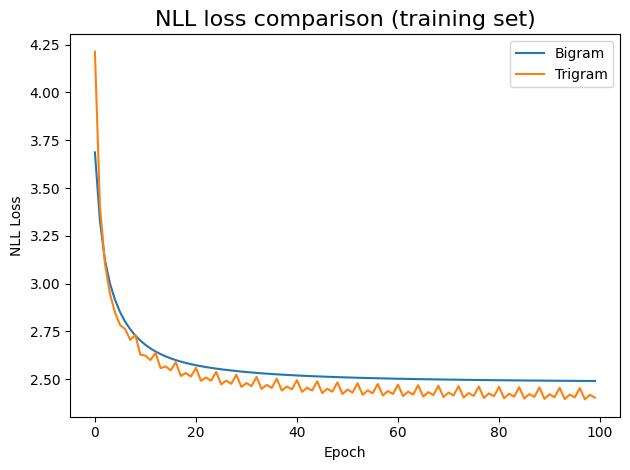

In [52]:
# Losses obtained during training bigram/trigram models
loss_histories = {
    "Bigram": bigram_model.history.values(),
    "Trigram": trigram_model.history.values(),
}

# Joining results in a DataFrame
comparison_df = pd.DataFrame(loss_histories)

# Plotting the comparison
comparison_df.plot()
plt.xlabel("Epoch")
plt.ylabel("NLL Loss")
plt.title("NLL loss comparison (training set)", fontsize=16)
plt.tight_layout()
plt.show()

In [54]:
bigram_model.generate_sample(num_examples=10, itos=itos)

['ayl',
 'eeiey',
 'viannmonind',
 'pidouyra',
 'jon',
 'cerrdyanaya',
 'kseli',
 'peyussmon',
 'zzolie',
 'e']

In [55]:
trigram_model.generate_sample(num_examples=10, itos=itos)

['kyl',
 'ee',
 'elevtonnalizyr',
 'piuouyra',
 'joden',
 'rreyana',
 'mik',
 'jlia',
 'dyussmon',
 'zeriel']

# Exercise 3

In [58]:
strengths = np.arange(0.00, 0.11, 0.01)
strengths

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [61]:
# Preallocating a variable for best loss selection
best_dev_loss = np.inf
# Preallocating a variable for storing best regularization rate
best_strength = 0
# Preallocating a variable for storing the best model
best_model = None

# Launching tuning procedure
for strength in strengths:
    # Instantiating a model
    model = TrigramModel(
        num_features=54, 
        num_out=27,
        num_epochs=100,
        learning_rate=50, 
        regularize=True, 
        smooth_strength=strength,
        enable_tqdm=False,
    )
    
    # Training
    model.fit(X_train_trigram, Y_train_trigram)
    
    # Computing train/dev loss
    train_loss = model(X_train_trigram, Y_train_trigram).item()
    dev_loss = model(X_dev_trigram, Y_dev_trigram).item()
    
    # Making a decision about the best smoothing strength
    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        best_strength = strength
        best_model = model
    
    # Logging the results
    print(f"strength = {strength:.2f}: train_loss = {train_loss:.4f}, dev_loss = {dev_loss:.4f}")
    
print(f"\nBest dev loss: {best_dev_loss:.4f}")
print(f"Best strength: {best_strength:.2f}")

test_loss = best_model(X_test_trigram, Y_test_trigram).item()
print(f"\nTest set loss: {test_loss:.4f}")

strength = 0.00: train_loss = 2.4427, dev_loss = 2.4372
strength = 0.01: train_loss = 2.4522, dev_loss = 2.4469
strength = 0.02: train_loss = 2.4617, dev_loss = 2.4565
strength = 0.03: train_loss = 2.4694, dev_loss = 2.4643
strength = 0.04: train_loss = 2.4765, dev_loss = 2.4716
strength = 0.05: train_loss = 2.4836, dev_loss = 2.4788
strength = 0.06: train_loss = 2.4897, dev_loss = 2.4850
strength = 0.07: train_loss = 2.4954, dev_loss = 2.4908
strength = 0.08: train_loss = 2.5010, dev_loss = 2.4964
strength = 0.09: train_loss = 2.5066, dev_loss = 2.5021
strength = 0.10: train_loss = 2.5115, dev_loss = 2.5071

Best dev loss: 2.4372
Best strength: 0.00

Test set loss: 2.4548


In [62]:
loss_set_df

,bigram_loss,trigram_loss
train,2.4899,2.4522
dev,2.4850,2.4469
test,2.4964,2.4642


# Exercise 4

We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [72]:

class BigramModelV2(BigramModel):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __call__(self, x, y):
        
        logits = self.weights[x]
        # Retrieving counts
        counts = logits.exp()
        # Computing probabilities for the next character
        probas = counts / counts.sum(1, keepdims=True)
        
        # Computing loss (w/wo regularization)
        if self.regularize:
            if self.smooth_strength is None:
                raise ValueError("Regularization rate not specified")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean() + self.smooth_strength * (self.weights**2).mean()
        else:
            if self.smooth_strength is not None:
                warnings.warn("Specifying regularization rate has no effect")
            loss = -probas[torch.arange(x.shape[0]), y].log().mean()
            
        return loss

In [73]:
bigram_model = BigramModelV2(
    num_features=27, 
    num_out=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

bigram_model.fit(X_train_bigram, Y_train_bigram)

  0%|          | 0/100 [00:00<?, ?it/s]

In [74]:
# Computing losses for the three sets
bigram_train_loss = bigram_model(X_train_bigram, Y_train_bigram).item()
bigram_dev_loss = bigram_model(X_dev_bigram, Y_dev_bigram).item()
bigram_test_loss = bigram_model(X_test_bigram, Y_test_bigram).item()

print(f"Train loss: {bigram_train_loss:.4f}")
print(f"Dev loss: {bigram_dev_loss:.4f}")
print(f"Test loss: {bigram_test_loss:.4f}")

Train loss: 2.4899
Dev loss: 2.4850
Test loss: 2.4964


In [75]:
loss_set_df

,bigram_loss,trigram_loss
train,2.4899,2.4522
dev,2.4850,2.4469
test,2.4964,2.4642


By simply indexing the rows of the weight matrix, we were able to slightly speed up the computations while achieving the same results as above.

# Exercise 5

 Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

## Bigram Model

In [76]:
class BigramModelV3(BigramModel):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __call__(self, x, y):
        logits = self.weights[x]
        # computing loss (w/wo regularization) 
        if self.regularize:
            if self.smooth_strength is None: 
                raise ValueError("Regularizaton rate not specified") 
            loss = F.cross_entropy(logits, y) + self.smooth_strength * (self.weights**2).mean() 
        else: 
            loss = F.cross_entropy(logits, y) 
        
        return loss 
                


In [78]:
bigram_model = BigramModelV2(
    num_features=27, 
    num_out=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

bigram_model.fit(X_train_bigram, Y_train_bigram)

# Computing losses for the three sets
bigram_train_loss = bigram_model(X_train_bigram, Y_train_bigram).item()
bigram_dev_loss = bigram_model(X_dev_bigram, Y_dev_bigram).item()
bigram_test_loss = bigram_model(X_test_bigram, Y_test_bigram).item()

print(f"Train loss: {bigram_train_loss:.4f}")
print(f"Dev loss: {bigram_dev_loss:.4f}")
print(f"Test loss: {bigram_test_loss:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Train loss: 2.4899
Dev loss: 2.4850
Test loss: 2.4964


## Trigram Model

In [ ]:
class TrigramModelV3(BigramModel):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __call__(self, x, y):
        
        logits = self.weights[x]
        
        # Computing loss (w/wo regularization)
        if self.regularize:
            loss = F.cross_entropy(logits, y) + self.smooth_strength * (self.weights**2).mean()
        else:
            loss = F.cross_entropy(logits, y)
            
        return loss
    
    

In [88]:
# Instantiating a trigram model
trigram_model = TrigramModel(
    num_features=54, 
    num_out=27,
    num_epochs=100, 
    learning_rate=50, 
    logging=False, 
    regularize=True, 
    smooth_strength=0.01,
)

trigram_model.fit(X_train_trigram, Y_train_trigram)

trigram_train_loss = trigram_model(X_train_trigram, Y_train_trigram).item()
trigram_dev_loss = trigram_model(X_dev_trigram, Y_dev_trigram).item()
trigram_test_loss = trigram_model(X_test_trigram, Y_test_trigram).item()

print(f"Train loss: {trigram_train_loss:.4f}")
print(f"Dev loss: {trigram_dev_loss:.4f}")
print(f"Test loss: {trigram_test_loss:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Train loss: 2.4522
Dev loss: 2.4469
Test loss: 2.4642


In [89]:
loss_set_df

,bigram_loss,trigram_loss
train,2.4899,2.4522
dev,2.4850,2.4469
test,2.4964,2.4642
